In [1]:
from lib import *
import scipy.special
import matplotlib
from tqdm.notebook import tqdm

# Spektrum

In [2]:
def calculate_spectrum(N, H0_method, V, R=1, m=1) -> tuple[np.ndarray, np.ndarray]:
    H = create_H_op(H0_method, V, R=R, m=m)
    E_arr, E_states = H.eigh(N)
    return E_arr.real, E_states

In [3]:
def remove_degeneracy(spectrum: tuple[np.ndarray, np.ndarray]):
    E_arr, E_states = spectrum
    E_arr, nondeg_indices = np.unique(E_arr.round(decimals=6), return_index=True)
    E_states = E_states[nondeg_indices]
    return E_arr, E_states

def remove_pair_degeneracy(spectrum: tuple[np.ndarray, np.ndarray]):
    E_arr_deg, E_states_deg = spectrum

    # Test degeneracy
    # if not np.allclose(E_arr_deg[::2], E_arr_deg[1::2]):
    #     raise ValueError("Spectrum does not consist of degenerate pairs.")

    # Standardize states
    E_states_deg = np.array([standardize_phi(state).real for state in E_states_deg])

    # Remove degeneracy, add connected states
    E_arr = E_arr_deg[::2]
    E_states1 = E_states_deg[::2]
    E_states2 = E_states_deg[1::2]

    E_states = E_states1 + E_states2

    return E_arr, E_states

def plot_spectrum_with_wavefuncs(method, n_arr, x_arr, E_arr, E_states, omega, ax=None):
    ax = ax or plt.gca()
    
    E_max = E_arr[n_arr].max()

    for color, n in reversed(list(colorize(n_arr))): # Reverse to have lowest n on bottom
        E_state = E_states[n]
        E = E_arr[n]
        y = E + E_state * E_max / n_arr.max() * 2
        y /= hbar * omega

        # Plot spectrum lines
        ax.plot(x_arr, y, color=color, label=f"$E_{n}" + ("^\\mathrm{" + method + "}" if method != "ana" else "") + f" = {fmt_tex(E / (hbar * omega), '%.3f')} \\, \\hbar\\omega$")        
        ax.fill_between(x_arr, E / (hbar * omega), y, color=color, alpha=.1)     
        
        # Energy level labels
        # ax.text(x_arr.max() * .85, E + .02 * E_max, f"$n = {n}$", color=color, size=12)

        # ax.axhline(n + 1/2, color=color, ls="--", lw=1, alpha=.5)

    
    ax.set_ylim(-.05 * E_max / (hbar * omega), 1.2 * E_max / (hbar * omega))
    ax.set_xlim(-.6, .8)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$E / \\hbar\\omega$")
    ax.legend(loc="upper right")


def analyze_energy_spectrum(N, V, omega, E_expected_func=None, E_state_expected_func=None, R=1, part=np.real, max_y=6.8, filename="energiespektrum"):
    x_arr = x_vals(N).real

    n_arr = np.arange(6, dtype=int)
    V_arr = np.diag(as_op(V).compute_matrix(N)).real

    methods = H0_methods if E_expected_func is None and E_state_expected_func is None else ["ana", *H0_methods]

    fig, axes = plt.subplots(len(methods), 1, figsize=(7, 2.8 * len(methods)), sharex=True)


    for ax, method in zip(axes, methods):
        # E_arr, E_states = remove_pair_degeneracy(calculate_spectrum(N, method, V, R=R))
        if method == "ana":
            E_arr = np.array([E_expected_func(n) for n in n_arr])
            E_states = np.array([list(E_state_expected_func(n, x_arr)) for n in n_arr])
        else:
            E_arr, E_states = calculate_spectrum(N, method, V, R=R)

        plot_spectrum_with_wavefuncs(method, n_arr, x_arr, E_arr, part(E_states), omega, ax=ax)
        
        if ax is not axes[-1]:
            ax.set_xlabel(None)

        # Plot potential
        ax.plot(x_arr, V_arr / (hbar * omega), c="k", ls="--", lw=1)
        # ax.text(-.58, 1.03 * E_arr[n_arr].max(), "$V(x)$", color="k", size=12)
        
        ax.text(.02, .9, method, transform=ax.transAxes, size=12) 

        ax.set_ylim(-0.5, max_y)


    plt.subplots_adjust(hspace=0)
    # axes[0].legend()     
    plt.savefig(f"output/{filename}.pdf", bbox_inches="tight")
    plt.show()

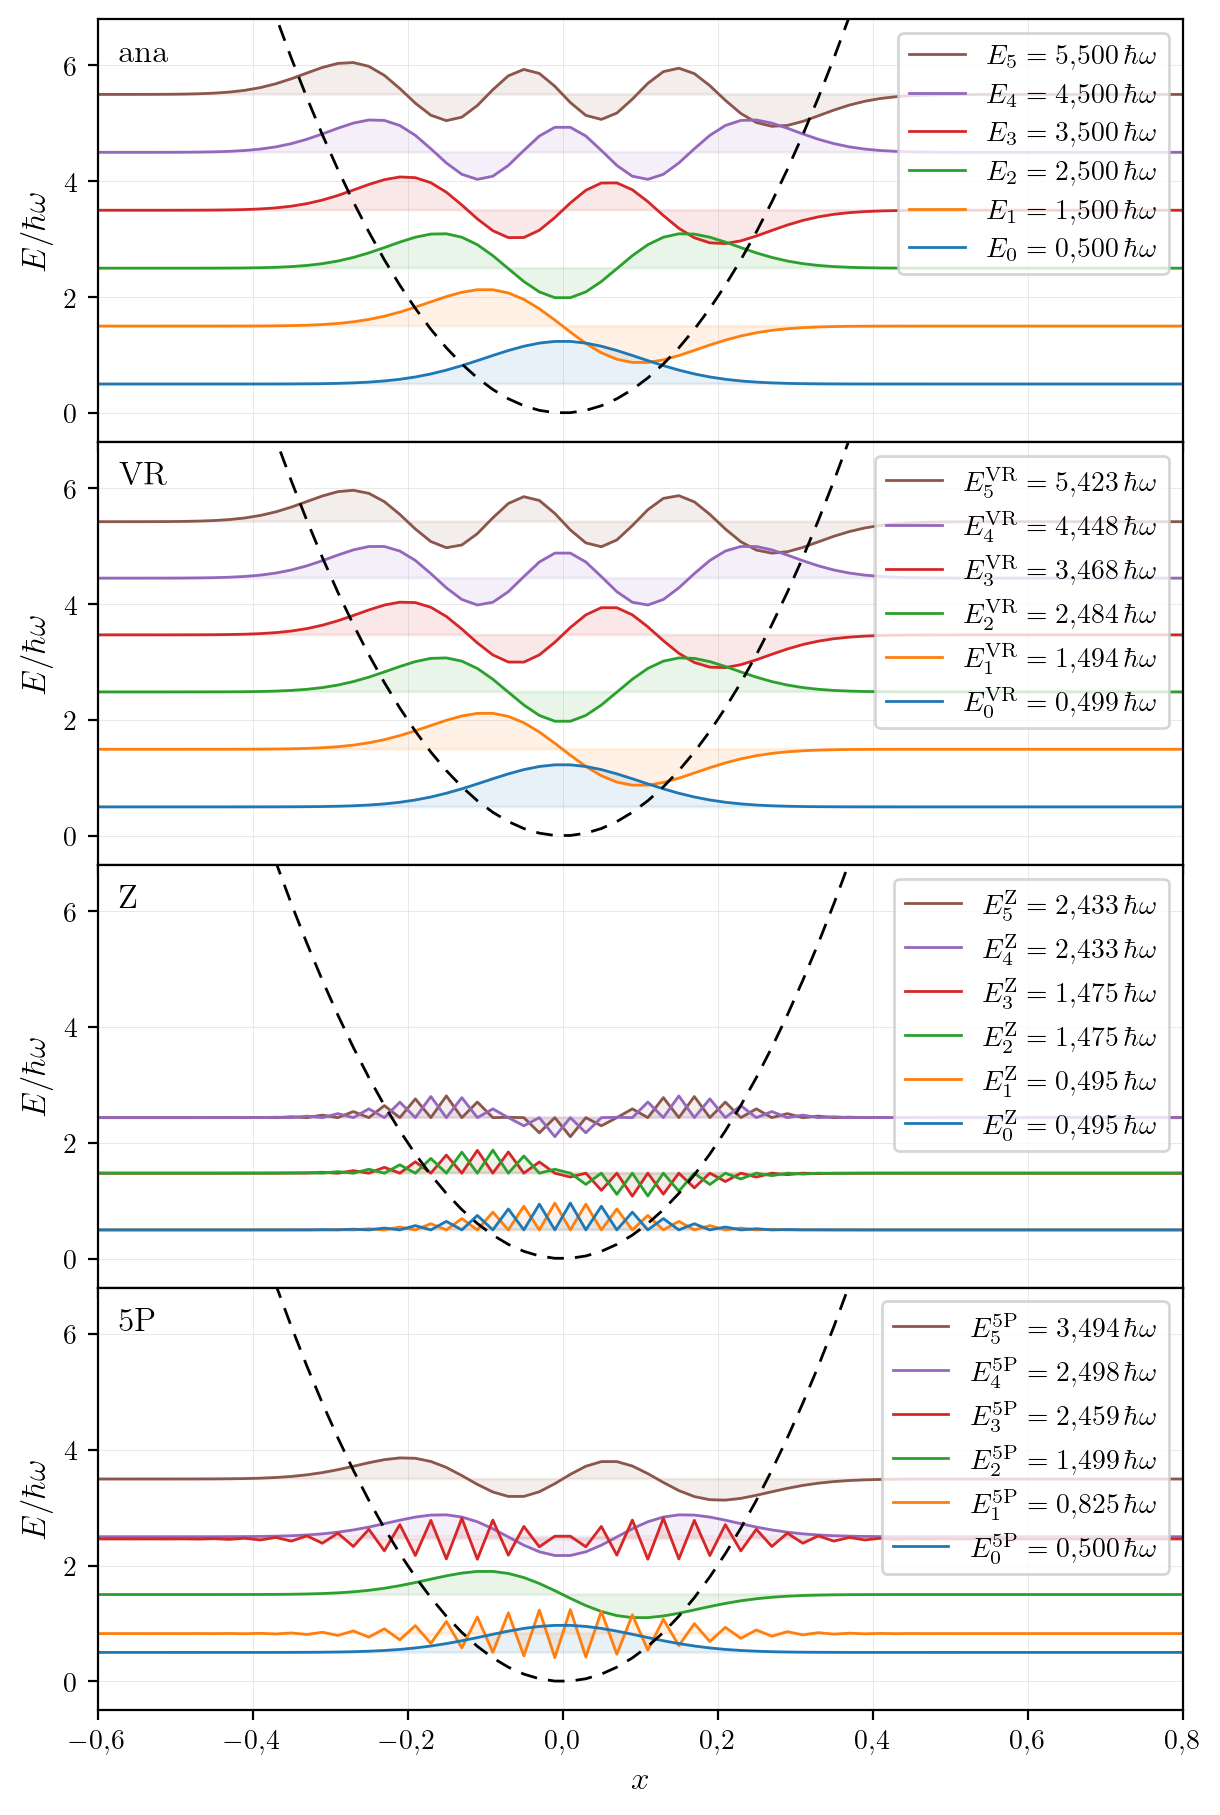

In [4]:
@functools.cache
def create_anharmonic_pot(omega, lambda_, m=1):
    return m * omega**2 * X_op**2 / 2 + lambda_ * m**2 * omega**3 / 4 / hbar * X_op**4

@functools.cache
def create_harmonic_E_func(omega):
    return lambda n: hbar * omega * (n + .5)

@functools.cache
def create_harmonic_E_state_func(omega, m=1):
    def func(n, x_arr):
        return standardize_phi(
            (m * omega / np.pi / hbar)**.25 / np.sqrt(2**n * math.factorial(n))
            * scipy.special.hermite(n)(x_arr * np.sqrt(m * omega / hbar))
            * np.exp(-m * omega * x_arr**2 / 2 / hbar)
        )
    return func

omega = 100
harmonic_pot = create_anharmonic_pot(omega, 0)
harmonic_E_func = create_harmonic_E_func(omega)
harmonic_E_state_func = create_harmonic_E_state_func(omega)
analyze_energy_spectrum(100, harmonic_pot, omega, harmonic_E_func, harmonic_E_state_func, R=1, filename="energiespektrum_N100_omega100_R1_lambda0")

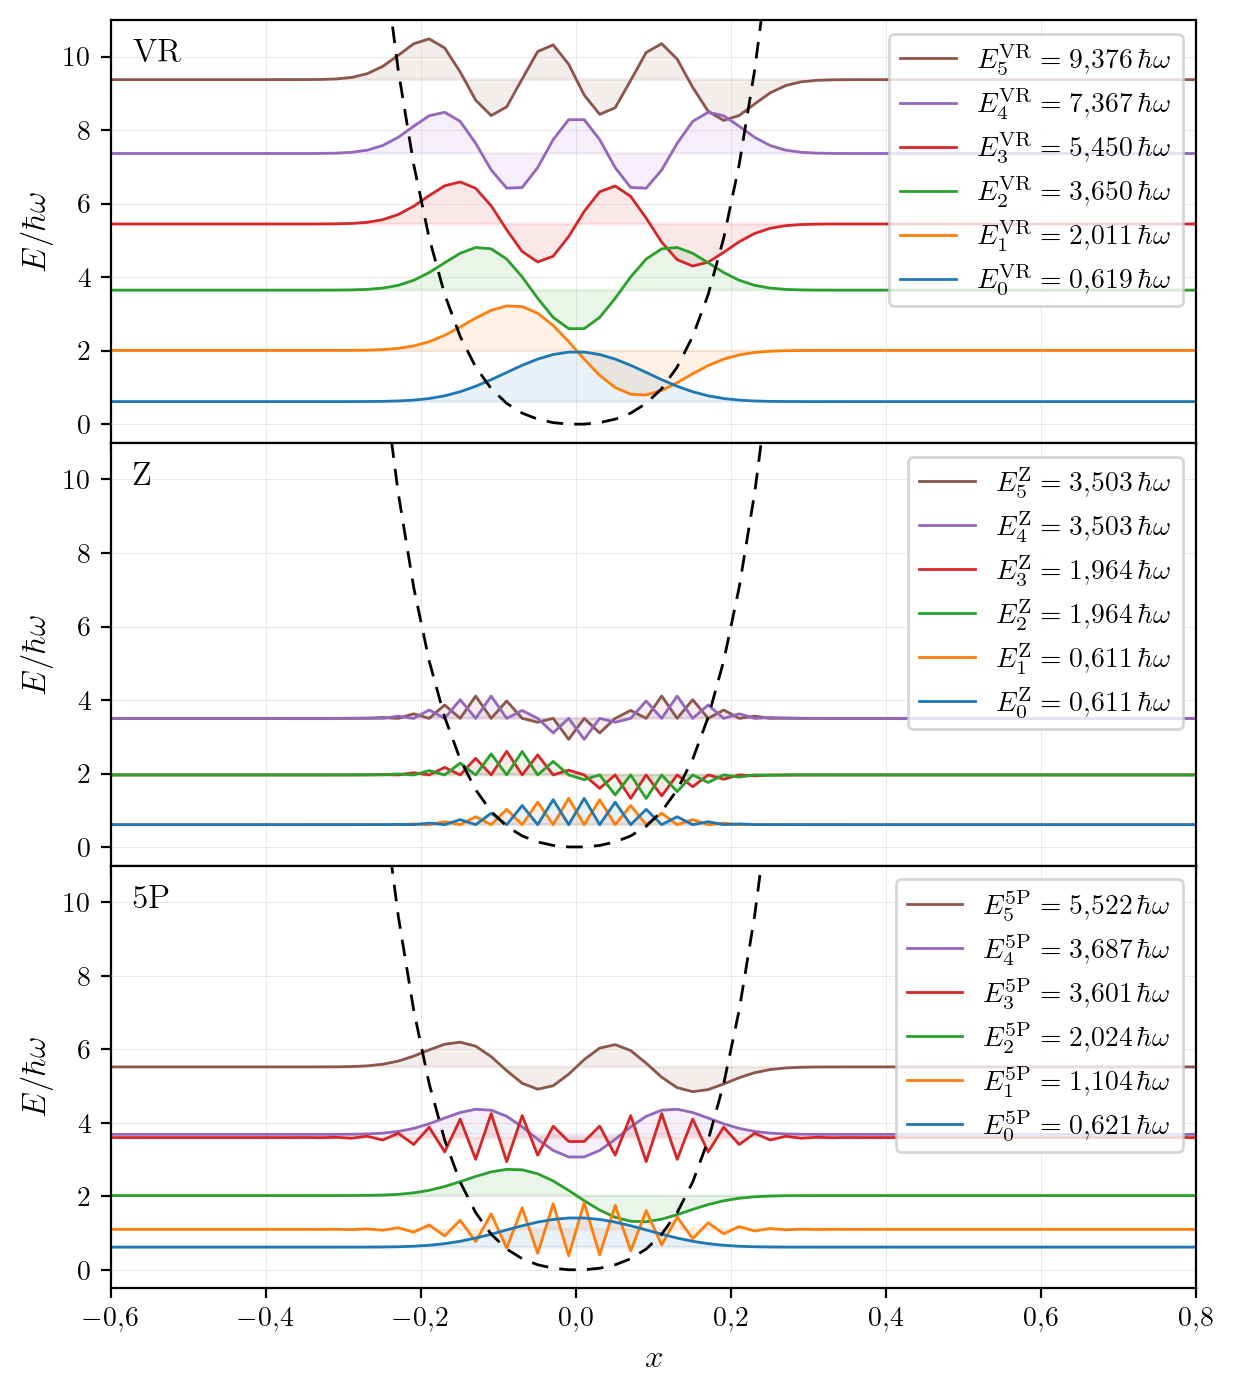

In [5]:
anharmonic_pot = create_anharmonic_pot(omega, 1)
analyze_energy_spectrum(100, anharmonic_pot, omega, R=1, max_y=11, filename="energiespektrum_N100_omega100_R1_lambda1")

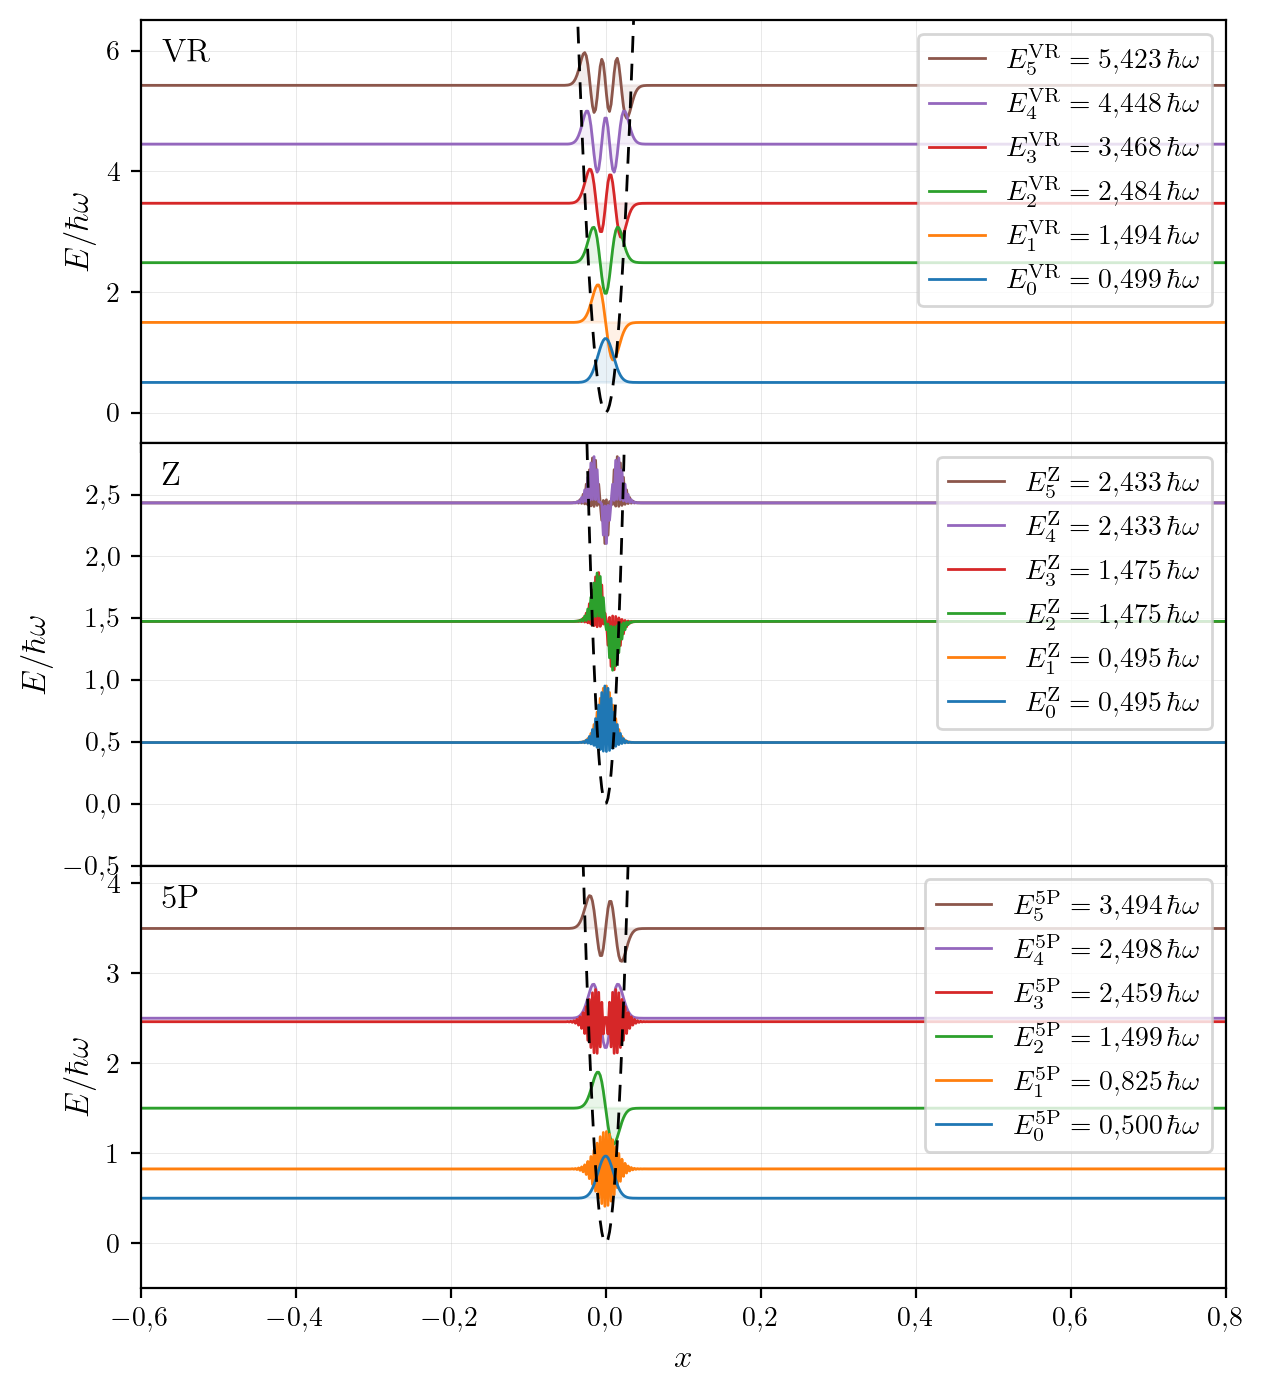

In [6]:
analyze_energy_spectrum(N=1000, V=create_anharmonic_pot(10000, 0), omega=10000, R=1, max_y=None, filename="energiespektrum_N1000_omega1000_R1_lambda0")

# $\Delta x$-Abhängigkeit des Spektrums

In [7]:
def analyze_energy_spectrum_N_dep(V, E_expected_func, omega):
    N_arr = np.logspace(1, 2.2, 30, dtype=int)
    dx_arr = np.array([calc_dx(N).real for N in N_arr])
    # N = np.arange(4, 50, 4, dtype=int)

    n_arr = np.arange(6, dtype=int)

    fig, axes = plt.subplots(len(H0_methods), 1, figsize=(7, 9), sharex=True)

    for ax, method in zip(axes, H0_methods):
        E_mat = np.full((len(n_arr), len(N_arr)), np.nan)
        E_exptected_arr = np.empty(len(n_arr))

        for n in n_arr:
            E_exptected_arr[n] = E_expected_func(n)

        for i, N in enumerate(N_arr):
            E_arr, _ = calculate_spectrum(N, method, V)
            
            for n, E in enumerate(E_arr):
                if n > n_arr.max(): break
                E_mat[n, i] = E

        # plt.title("Spektrum in Abhängigkeit von $N$")
        cmap = plt.get_cmap("viridis")

        for color, n in reversed(list(colorize(n_arr))):
            # Calculations
            ax.scatter(dx_arr, E_mat[n] / (hbar * omega), s=10, color=color, label=f"$E_{n}^\\mathrm" + "{" + method + "}$")
            ax.plot(dx_arr, E_mat[n] / (hbar * omega), color=color, alpha=.5)

            # # Expectations (energy levels)
            ax.axhline(E_exptected_arr[n] / (hbar * omega), color="k", ls="--", alpha=.2, zorder=-10)
            # # Energy level labels
            # ax.text(dx_arr.max() * 1.04, (E_exptected_arr[n] + .03 * E_exptected_arr.max()) / (hbar * omega), f"$E_{n}$", color=color, size=12)

        ax.set_ylabel("$E / \\hbar \\omega$")
        ax.set_ylim(0, 6.8)
        
        ax.text(.02, .9, method, transform=ax.transAxes, size=12) 
        ax.legend(loc="upper right")

    # axes[0].legend()
    axes[-1].set_xlabel("$\\Delta x$")
    axes[-1].set_xscale("log")
    # axes[0].legend(loc="upper right")
        
    plt.subplots_adjust(hspace=0)
    plt.savefig(f"output/energy_spectrum_N_dep.pdf", bbox_inches="tight")
    plt.show()

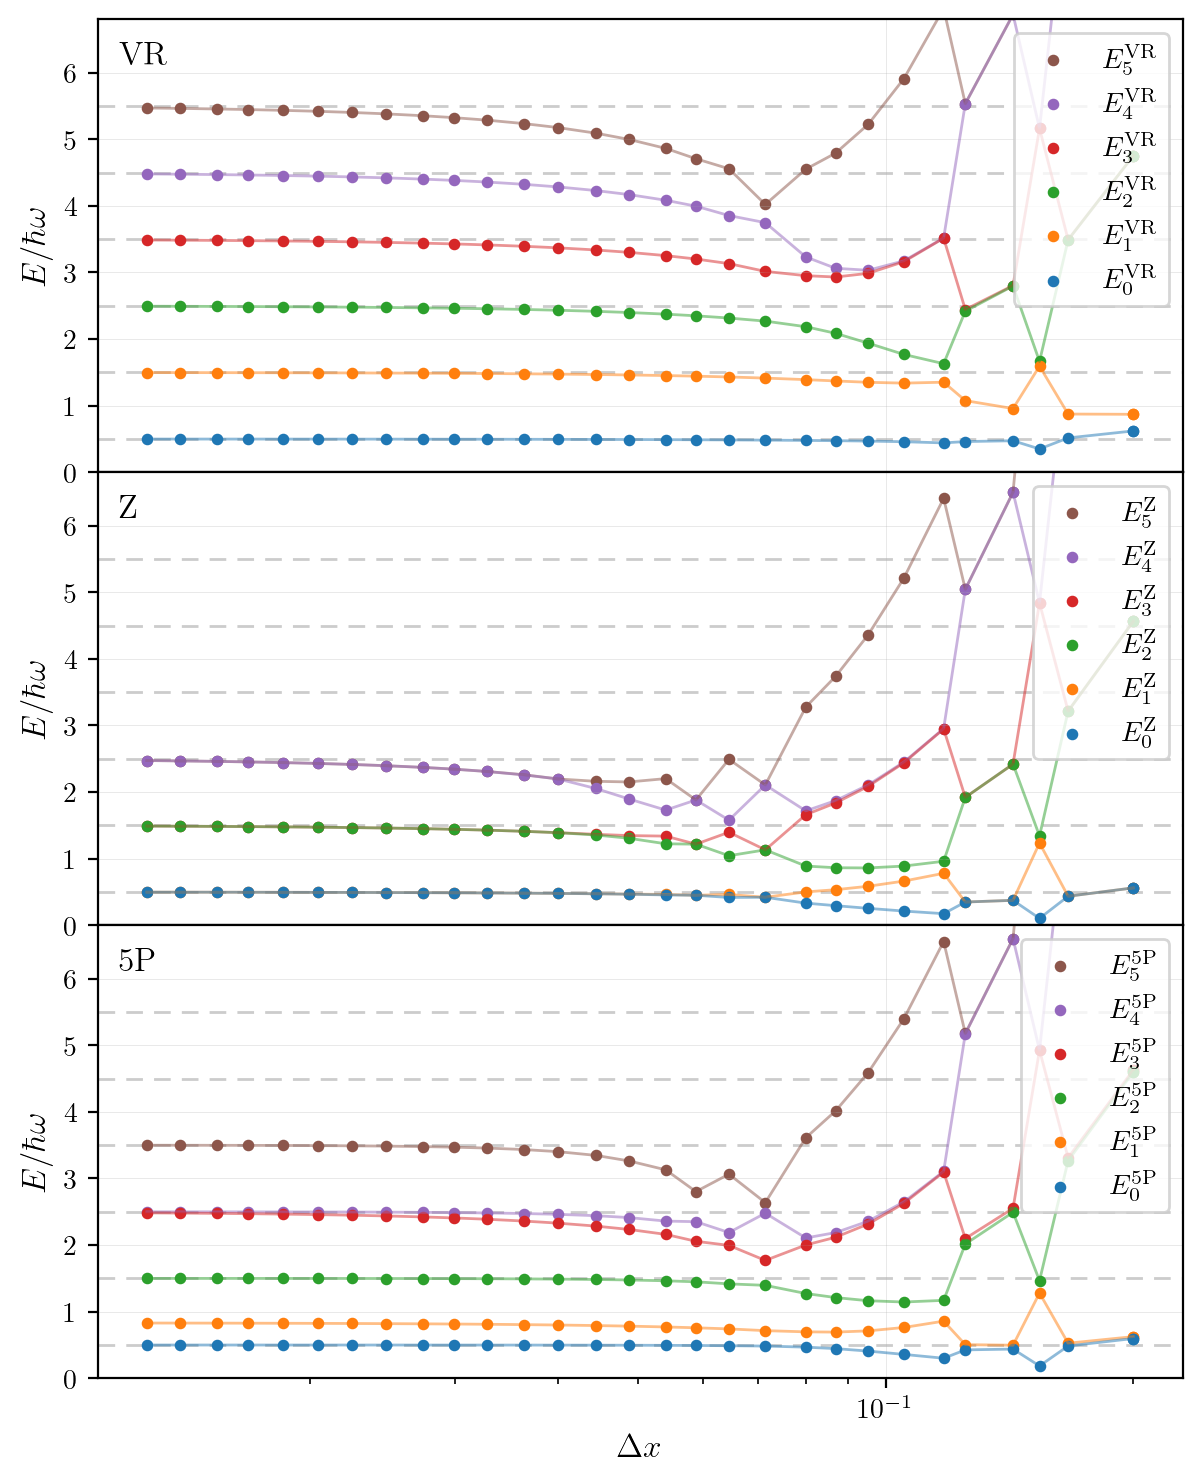

In [8]:
analyze_energy_spectrum_N_dep(harmonic_pot, harmonic_E_func, omega)

# Grundzustandsenergie

VR: alpha = 2,00188 +/- 0,00022, beta = 5,75459 +/- 0,00099, chi^2/dof = 5,2e-07
Z: alpha = 2,00776 +/- 0,00089, beta = 7,17203 +/- 0,00417, chi^2/dof = 9,25e-06
5P: alpha = 3,98883 +/- 0,00115, beta = 10,98346 +/- 0,00539, chi^2/dof = 1,55e-05


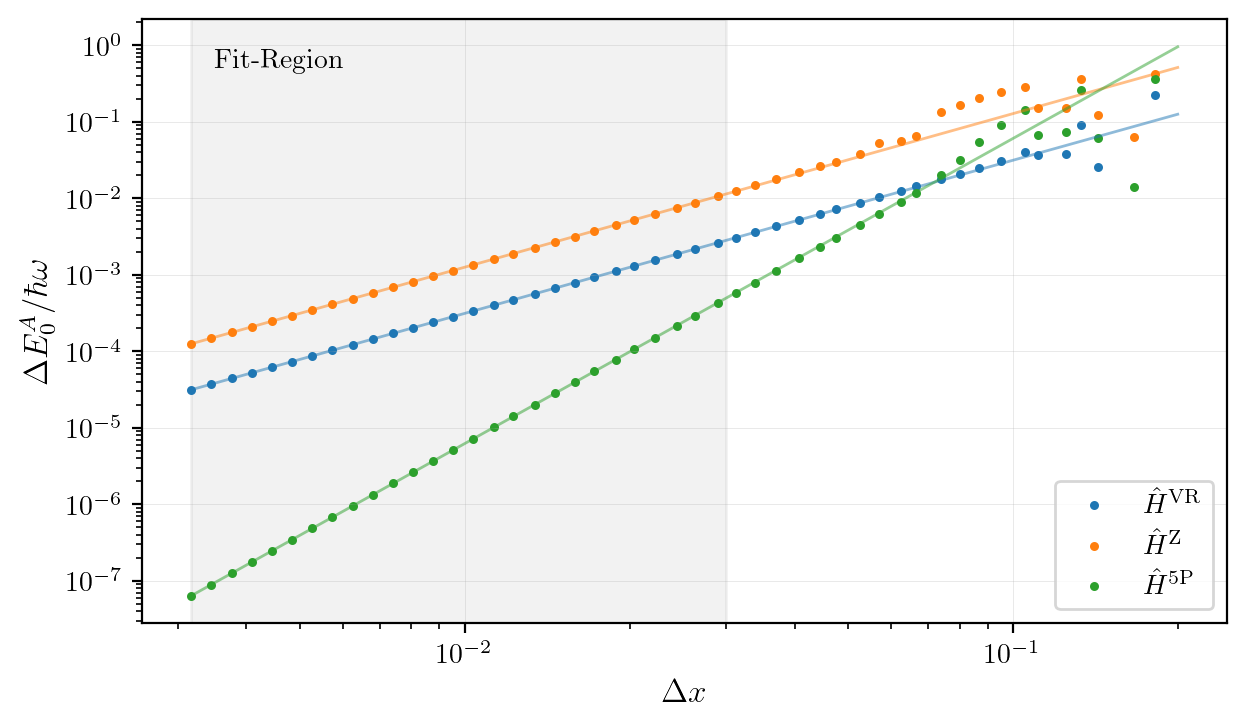

In [9]:
def calc_chi_squ_dof(x, y, params):
    dof = len(x) - len(params)
    chi_sq = np.sum((np.polyval(params, x) - y) ** 2)
    return chi_sq / dof

def analyze_ground_energy_convergence(V, E_expected_func, omega, n=0, m_dict={}):
    N_arr = np.logspace(1, 2.8, 50, dtype=int)
    dx_arr = np.array([calc_dx(N).real for N in N_arr])
    E_expected = E_expected_func(n)

    max_linear_dx = 3e-2

    for color, method in colorize(H0_methods):
        dE_arr = np.empty(len(N_arr))
        m = m_dict.get(method, n)
        
        for i, N in enumerate(N_arr):
            N_E_arr, _ = calculate_spectrum(N, method, V, R=1)
            dE_arr[i] = E_expected - N_E_arr[m]
        

        plt.scatter(dx_arr, dE_arr / (hbar * omega), s=5, color=color, label="$\\hat H^\\mathrm{" + method + "}$")


        linear = dx_arr < max_linear_dx

        (alpha, beta), cov = np.polyfit(np.log(dx_arr[linear]), np.log(dE_arr[linear]), 1, cov=True)
        alpha_err, beta_err = np.sqrt(np.diag(cov))
        chi_squ = calc_chi_squ_dof(np.log(dx_arr[linear]), np.log(dE_arr[linear]), (alpha, beta))
        print(f"{method}: alpha = {fmt((alpha, alpha_err), 5)}, beta = {fmt((beta, beta_err), 5)}, chi^2/dof = {fmt(chi_squ)}")

        plt.plot(dx_arr, np.exp(beta) * dx_arr**alpha / (hbar * omega), color=color, alpha=.5)

    plt.axvspan(dx_arr.min(), max_linear_dx, color="k", alpha=.05, zorder=-1)
    plt.text(dx_arr.min() * 1.1, .5, "Fit-Region", color="k")

    # axes[0].legend()
    plt.xlabel("$\\Delta x$")
    plt.xscale("log")
    plt.ylabel(f"$\\Delta E_{n}^A / \\hbar \\omega$")
    plt.yscale("log")
    plt.legend(loc="lower right")

    plt.savefig(f"output/ground_energy_convergence.pdf", bbox_inches="tight")
    plt.show()

analyze_ground_energy_convergence(harmonic_pot, harmonic_E_func, omega)

# Zeitentwicklung

dt = 5e-05


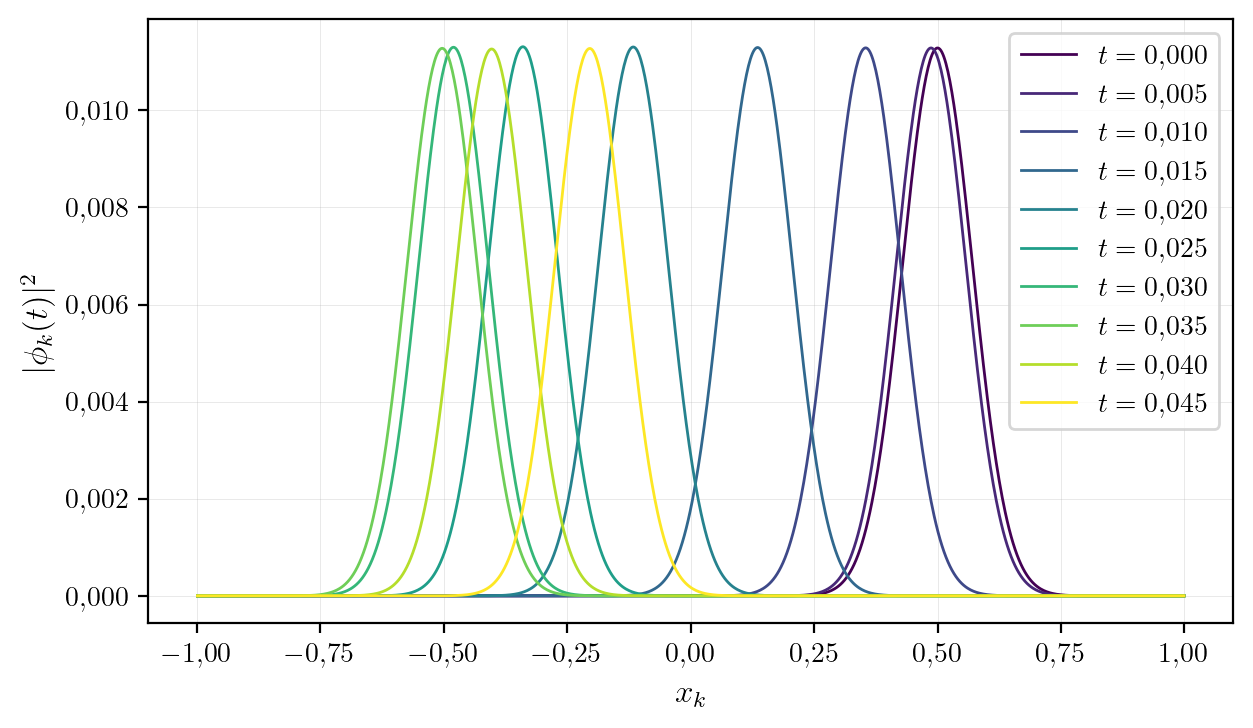

In [10]:
@functools.cache
def create_U_op(N, H_op, dt):
    return ExpOp(-1j * H_op * dt / hbar)

def time_evolution(H0_method, V, phi0, dt=1e-2, steps=100):
    phi0 = phi0.astype(np.complex128)
    N = len(phi0)

    H_op = create_H_op(H0_method, V, R=0)

    phi_arr = np.empty((steps, len(phi0)), dtype=np.complex128)
    phi_arr[0] = phi0
    
    U_op = create_U_op(len(phi0), H_op, dt)

    for j in range(1, steps):
        phi_arr[j] = U_op * phi_arr[j - 1]

    return phi_arr

def analyze_time_evolution(H0_method, V, psi0, frames=10, steps_per_frame=100, duration=1, animated=False):
    steps = frames * steps_per_frame
    dt = duration / steps
    print(f"dt = {dt:.3g}")
    phi_arr = time_evolution(H0_method, V, psi0, dt, steps)
    phi_arr = phi_arr[::steps_per_frame]
    prob_arr = np.abs(phi_arr)**2
    
    x_arr = x_vals(len(psi0)).real

    plt.xlabel("$x_k$")
    plt.ylabel("$|\\phi_k(t)|^2$")

    if not animated:
        for color, frame in colorize(range(frames), "viridis", continuous=True):
            t = frame * steps_per_frame * dt
            plt.plot(x_arr, prob_arr[frame], label=f"$t = {fmt_tex(t, '%.3f')}$", color=color)
        
        plt.legend()
        plt.savefig("output/time_evolution.pdf")
        plt.show()
    else:
        ax = plt.gca()
        line, = plt.plot(x_arr, prob_arr[0])

        def animate(frame):
            t = frame * steps_per_frame * dt
            ax.set_title(f"$t = {fmt_tex(t, '%.3f')}$")
            line.set_ydata(prob_arr[frame])
            return line,

        anim = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=steps, interval=20)

        anim.save("output/time_evolution.gif")


def delta_wavefunc(arr, val):
    result = np.zeros_like(arr)

    min_diff = np.inf
    min_diff_index = None
    for i in range(len(arr)):
        diff = np.abs(arr[i] - val)
        if diff < min_diff:
            min_diff = diff
            min_diff_index = i

    result[min_diff_index] = 1

    return result / np.linalg.norm(result)

time_evolution_psi0 = create_coherent_phi(1000, omega=100, q=.5, p=10)
analyze_time_evolution(
    "VR",
    harmonic_pot,
    time_evolution_psi0,
    duration=.05,
    frames=10,
    steps_per_frame=100,
)

In [11]:
# analyze_time_evolution(
#     "VR",
#     harmonic_pot,
#     time_evolution_psi0,
#     t_arr=np.linspace(0, .1, 300),
#     animated=True
# )

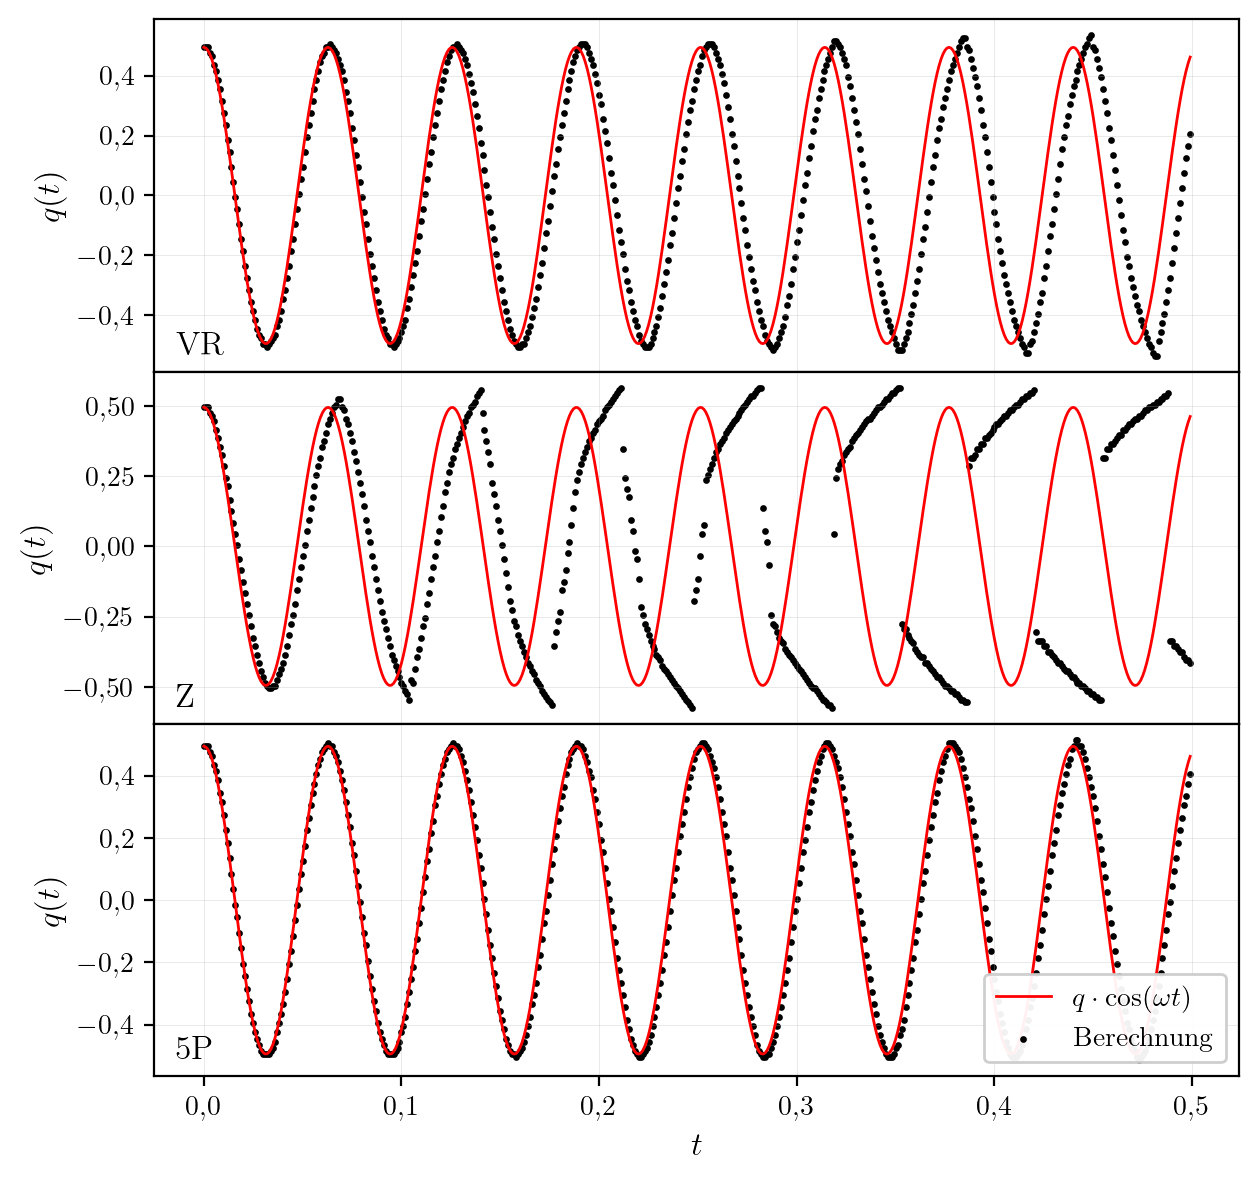

In [12]:
def compute_q_evolution(H0_method, V, phi0, dt, steps):
    psi_arr = time_evolution(H0_method, V, phi0, dt, steps)
    
    x_arr = x_vals(len(phi0)).real
    psi_max_indices = np.array([np.abs(psi).argmax() for psi in psi_arr])
    return x_arr[psi_max_indices]

def find_zero_transitions(t_arr, x_arr, pause_steps=10):
    i_trans = []
    for i in range(1, len(t_arr)):
        last_x = x_arr[i-1]
        x = x_arr[i]
        di = i - i_trans[-1] if len(i_trans) > 0 else np.inf
        
        if x <= 0 and last_x > 0 and di > pause_steps:
            i_trans.append(i)
    return np.array(i_trans)

def analyze_q_evolution(V, phi0, dt=1e-3, steps=500, start_t=0, filename="time_evolution_q", show_t0=False):
    fig, axes = plt.subplots(len(H0_methods), 1, figsize=(7, 7), sharex=True)

    t_arr = np.arange(steps) * dt + start_t

    for ax, method in zip(axes, H0_methods):
        if start_t > 0:
            phi = time_evolution(method, V, phi0, dt=start_t, steps=2)[-1]
        else:
            phi = phi0
        
        q_arr = compute_q_evolution(method, V, phi, dt, steps)


        ax.scatter(t_arr, q_arr, s=2, color="k", label="Berechnung")

        ax.plot(t_arr, q_arr[0] * np.cos(omega * t_arr), color="r", label="$q \\cdot \\cos(\\omega t)$")

        ax.set_ylabel("$q(t)$")
        ax.text(.02, .05, method, transform=ax.transAxes, size=12)
         
        if show_t0:
            # Find zero transition
            for j, i_trans in enumerate(find_zero_transitions(t_arr, q_arr)):
                t_trans = t_arr[i_trans]
                print(f"{method}: t{j} = {fmt((t_trans, dt), 5)}")

                ax.axvline(t_trans, color="gray")
                ax.text(t_trans + (t_arr.max() - t_arr.min()) * .015, .47, "$t_{" + str(j) + "}$")
    
    axes[-1].legend(loc="lower right", framealpha=0.95)
    axes[-1].set_xlabel("$t$")
    plt.subplots_adjust(hspace=0)
    plt.savefig(f"output/{filename}.pdf")
    plt.show()

analyze_q_evolution(
    harmonic_pot,
    create_coherent_phi(200, q=.5, omega=100),
)

# Zeitlicher Verlauf der Abweichung

VR: t0 = 0,20615 +/- 0,00003
Z: t0 = 0,21188 +/- 0,00003
5P: t0 = 0,20448 +/- 0,00003


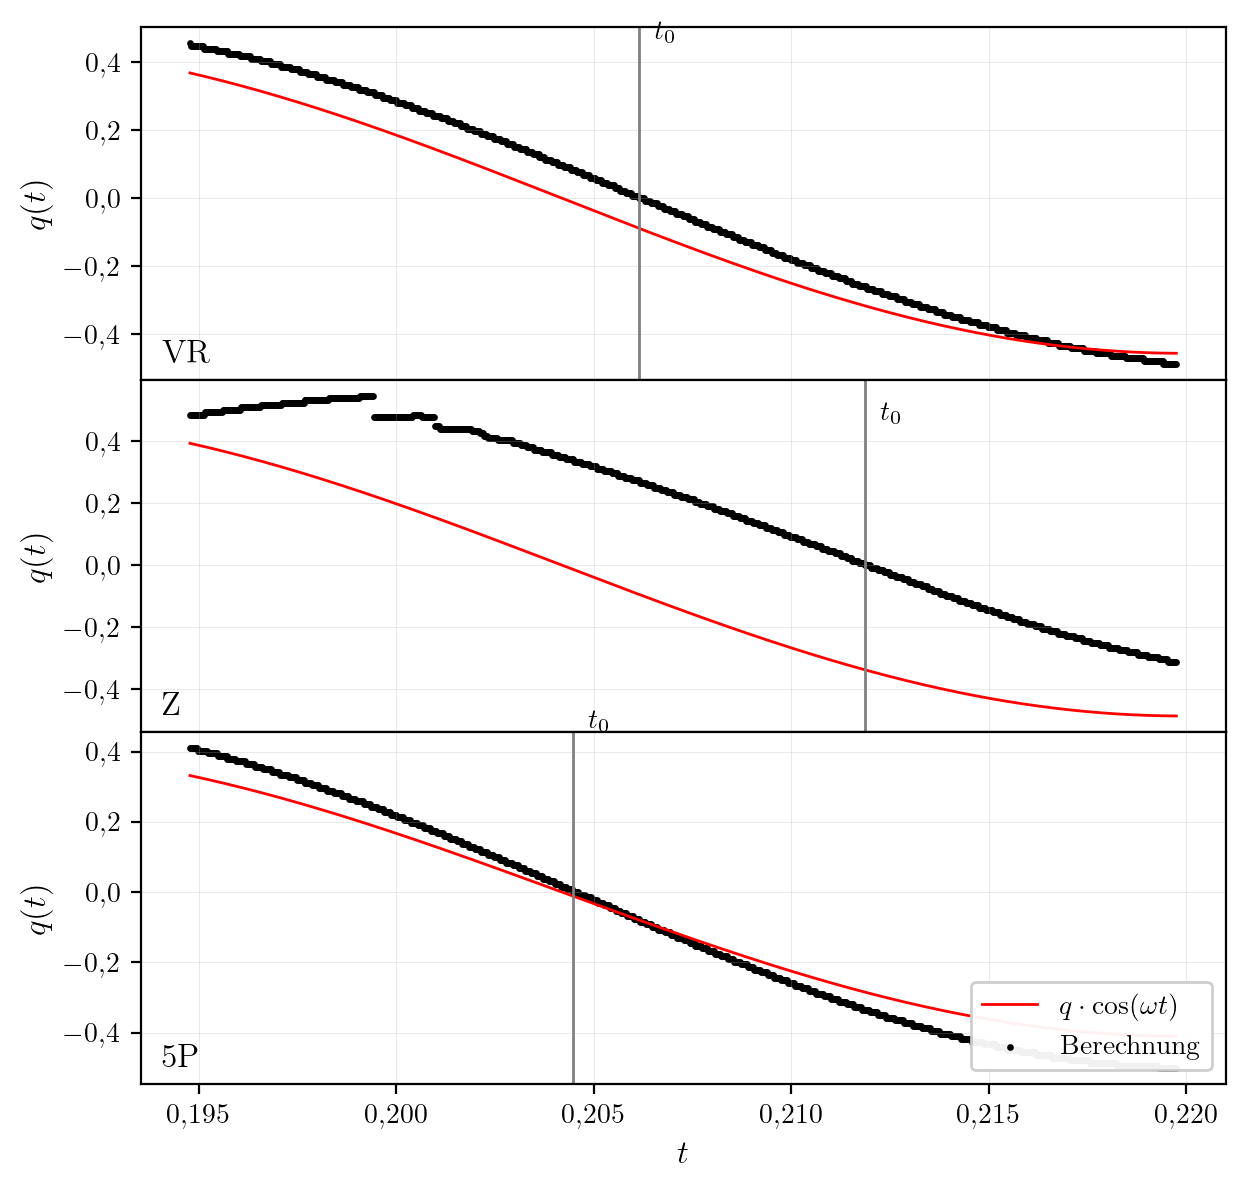

In [13]:
def periods(n, omega=omega):
    return n / omega * 2 * np.pi

# Test which dt and steps are good for zero transition measurement
analyze_q_evolution(
    harmonic_pot,
    create_coherent_phi(int(2 / 7.6e-3), q=.5, omega=omega),
    dt=2.5e-5, steps=1000,
    start_t=periods(3.1),
    filename="__ignore",
    show_t0=True
)

  0%|          | 0/50 [00:00<?, ?it/s]

VR: alpha = 2.003 ± 0.01572, beta = 3.542 ± 0.07781, chi^2/dof = 0.000514


  0%|          | 0/50 [00:00<?, ?it/s]

Z: alpha = 1.985 ± 0.007506, beta = 4.829 ± 0.03712, chi^2/dof = 0.000115


  0%|          | 0/50 [00:00<?, ?it/s]

5P: alpha = 4.553 ± 0.1919, beta = 14.08 ± 0.9501, chi^2/dof = 0.0765


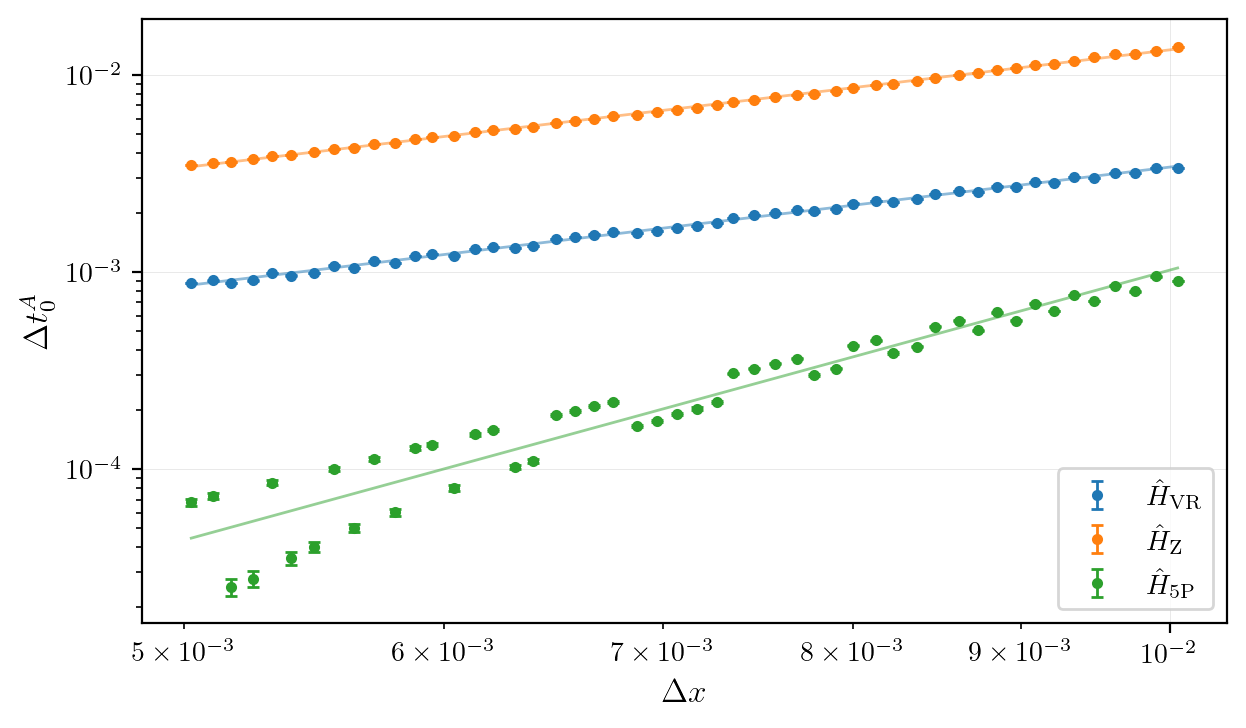

In [14]:
def analyze_dt0_dx_dep(q=.5, p=0, omega=100, dt=8e-6, steps=5000, start_t=0):
    N_arr = np.logspace(2.3, 2.6, 50, dtype=int)
    dx_arr = np.array([calc_dx(N).real for N in N_arr])
    t_arr = np.arange(steps) * dt + start_t

    trans_n = int(start_t * omega / (2 * np.pi))

    # 0 = q * np.cos(omega * t0)
    # => np.cos(omega * t0) = 0
    # => t0 = arccos(0) / omega = pi/2 / omega
    t0_exp = (np.pi / 2 + 2 * trans_n * np.pi) / omega

    # max_linear_dx = 8e-3

    for color, method in colorize(H0_methods):
        dt0_arr = []
        weights = []

        for N in tqdm(N_arr):
            phi0 = create_coherent_phi(N, q=q, omega=omega, p=p)
            pot = create_anharmonic_pot(omega, 0)
            
            if start_t > 0:
                phi0 = time_evolution(method, pot, phi0, start_t, 2)[-1]

            q_arr = compute_q_evolution(method, pot, phi0, dt=dt, steps=steps)
            
            i_trans_arr = find_zero_transitions(t_arr, q_arr)
            if len(i_trans_arr) > 0:
                i0 = i_trans_arr[0]
                t0 = t_arr[i0]
                dt0 = np.abs(t0_exp - t0)
                dt0_arr.append(dt0)

                weights.append(1 / np.abs(np.log(t_arr[i0-1]) - np.log(t0)))
            else:
                dt0_arr.append(np.nan)
                weights.append(np.nan)

        weights = np.array(weights)

        dt0_arr = np.array(dt0_arr)

        plt.errorbar(dx_arr, dt0_arr, yerr=dt, color=color, fmt=".", capsize=2, label="$\\hat H_\\mathrm{" + method + "}$")

        if np.isnan(dt0_arr).all():
            continue
        
        linear = np.ones_like(dx_arr, dtype=bool) #dx_arr < max_linear_dx

        (alpha, beta), cov = np.polyfit(np.log(dx_arr[linear]), np.log(dt0_arr[linear]), 1, cov=True, w=weights[linear])
        (alpha_err, beta_err) = np.sqrt(np.diag(cov))
        chi_squ = calc_chi_squ_dof(np.log(dx_arr[linear]), np.log(dt0_arr[linear]), (alpha, beta))
        print(f"{method}: alpha = {alpha:.4g} ± {alpha_err:.4g}, beta = {beta:.4g} ± {beta_err:.4g}, chi^2/dof = {chi_squ:.3g}")

        fit_y = np.exp(beta) * dx_arr ** alpha
        plt.plot(dx_arr, fit_y, color=color, alpha=.5)
        

        # fit_log_region(dx_arr, x_max_err_arr, plot=dict(color=color, lw=2, label="Fit"))

    # plt.axhline(t0_exp)
        
    # plt.axvspan(dx_arr.min(), max_linear_dx, color="k", alpha=.05, zorder=-1)
    # plt.text(dx_arr.min() * 1.1, 9e-3, "Fit-Region", color="k")

    plt.xlabel("$\\Delta x$")
    plt.ylabel("$\\Delta t_0^A$")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.savefig("output/dt0_dx_dep.pdf")
    plt.show()

analyze_dt0_dx_dep(dt=2.5e-6, steps=10000, start_t=periods(3.1))